# Gyms

- Top 40 gym
- Novelty Gym
- Diversity Gym
- Rewind Gym



In [201]:
import pandas as pd

tracks = pd.read_csv('./tracks.csv', index_col=0)

In [423]:
import gym
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
from functools import partial
from numbers import Number

class MusicGym(gym.Env):
    def __init__(self, N=40, limit=10000):
        self.tracks = pd.read_csv('./tracks.csv', index_col=0).dropna().reindex()
        self.action_space = spaces.Discrete(self.tracks.shape[0])
        self.observation_space = spaces.Discrete(1)
        self.tracks['created'] = pd.to_datetime(self.tracks['created'])
        self.max_date = self.tracks['created'].max()
        self.min_date = self.tracks['created'].min()
        
    def _context(self, action):
        row = self.tracks.loc[action]
        return {
            'genre': row['top_genre'], 
            'age': (self.max_date - row['created']).seconds, 
            'popularity': row['listens']
        }
    
        

class TopNGym(MusicGym):
    '''
    Give this person the top N tracks and that's it.
    
    This is the popular radio station approach and could be applied as well to content
    '''
    
    def __init__(self, N=40, limit=10000):
        self.topn = set(tracks.sort_values(by='listens', ascending=False).iloc[:N].index)
        super(TopNGym, self).__init__()
        
    def reset(self):
        return 0
    
    def step(self, action):
        assert self.action_space.contains(action)
        
        done = True
        
        if action in self.topn:
            reward = 1
        else:
            reward = 0
        
        return 0, reward, done, self._context(action)

class NoveltyGym(MusicGym):
    '''
    If the track hasn't been seen before it'll be higher weighted
    
    The newer the better
    '''
    
    def __init__(self):
        super(NoveltyGym, self).__init__()
        self.midpoint = (self.max_date - self.min_date)/2
        
    def reset(self):
        return 0
    
    def step(self, action):
        assert self.action_space.contains(action)

        done = True
        
        age = (self.tracks.loc[action]['created'] - self.min_date)
        
        if age > self.midpoint:
            reward = 1
        else:
            reward = 0
        
        return 0, reward, done, self._context(action)
    
from collections import Counter
class DiversityGym(MusicGym):
    '''
    This gym focuses on diversity.
    
    Basically someone who likes Jazz, Punk, Whatever, as long as it's different
    '''
    def __init__(self):
        self.reset()
        super(DiversityGym, self).__init__()
    
    def reset(self):
        self.genres = Counter()
        return 0
    
    def step(self, action):
        assert self.action_space.contains(action)

        done = True
        
        genre = self.tracks.loc[action]['top_genre']
  
        if len(self.genres) > 0:
            vals = self.genres.values()
            max_val = max(vals)
            min_val = min(vals)
            midpoint = (max_val - min_val) / 2
            if self.genres[genre] <= midpoint:
                reward = 1
            else:
                reward = 0
        else:
            reward = 1

        self.genres[genre] += 1
        
        return 0, reward, done, self._context(action)

class RewindGym(MusicGym):
    '''
    Basically give this person one genre to listen to
    '''
    
    def __init__(self, top_genre='Electronic'):
        self.genre = top_genre
        super(RewindGym, self).__init__()
        self.reset()
        
    def reset(self):
        # self.genre = self.tracks.sample(n=1).iloc[0]['top_genre']
        return 0
    
    def _context(self, action):
        row = self.tracks.loc[action]

        return {
            'genre': row['top_genre'], 
            'age': (self.max_date - row['created']).seconds, 
            'popularity': row['listens']
        }
    
    def step(self, action):
        assert self.action_space.contains(action)

        done = True
        
        genre = self.tracks.loc[action]['top_genre']
        
        if genre == self.genre:
            reward = 1
        else:
            reward = 0
            
        return 0, reward, done, self._context(action)
    
[
    TopNGym().step(1),
    NoveltyGym().step(1),
    DiversityGym().step(1),
    RewindGym().step(2)
]

[(0, 0, True, {'genre': 'Hip-Hop', 'age': 48925, 'popularity': 514}),
 (0, 0, True, {'genre': 'Hip-Hop', 'age': 48925, 'popularity': 514}),
 (0, 1, True, {'genre': 'Hip-Hop', 'age': 48925, 'popularity': 514}),
 (0, 0, True, {'genre': 'Hip-Hop', 'age': 48919, 'popularity': 1151})]

In [389]:
TopNGym().step(0)

(0, 0, True, {'genre': 'Hip-Hop', 'age': 48927, 'popularity': 1293})

In [217]:
# g = DiversityGym()
# g.step(1)
# g.step(1)
# g.step(2)
# g.step(3)

(0, 1, True, {'genre': 'Pop', 'age': 77673, 'popularity': 50135})

In [208]:
# How did we do before?

class Policy(object):
    """
    A policy prescribes an action to be taken based on the memory of an agent.
    
    In the case of n-armed bandits there is no state to be stored but in the next chapter we will
    talk more about states. Contextual Bandits are a way of storing a more historical memory about someone.
    
    """
    def __str__(self):
        return 'generic policy'

    def choose(self, agent):
        return 0


class EpsilonGreedyPolicy(Policy):
    """
    The Epsilon-Greedy policy will choose a random action with probability
    epsilon and take the best apparent approach with probability 1-epsilon. If
    multiple actions are tied for best choice, then a random action from that
    subset is selected.
    """
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __str__(self):
        return '\u03B5-greedy (\u03B5={})'.format(self.epsilon)

    def choose(self, agent):
        if np.random.random() < self.epsilon:
            return np.random.choice(len(agent.value_estimates))
        else:
            action = np.argmax(agent.value_estimates)
            check = np.where(agent.value_estimates == agent.value_estimates[action])[0]
            if len(check) == 1:
                return action
            else:
                return np.random.choice(check)
            
class Agent(object):
    """
    An Agent is able to take one of a set of actions at each time step. The
    action is chosen using a strategy based on the history of prior actions
    and outcome observations.
    """
    def __init__(self, environment, policy, prior=0, gamma=None):
        self.policy = policy
        self.environment = environment
        self.k = environment.action_space.n
        self.prior = prior
        self.gamma = gamma
        self._value_estimates = prior*np.ones(self.k)
        self.action_attempts = np.zeros(self.k)
        self.t = 0
        self.last_action = None

    def __str__(self):
        return 'f/{}'.format(str(self.policy))

    def reset(self):
        """
        Resets the agent's memory to an initial state.
        """
        self._value_estimates[:] = self.prior
        self.action_attempts[:] = 0
        self.last_action = None
        self.t = 0
        self.environment.reset()

    def choose(self):
        action = self.policy.choose(self)
        self.last_action = action
        return action

    def observe(self, reward):
        self.action_attempts[self.last_action] += 1

        if self.gamma is None:
            g = 1 / self.action_attempts[self.last_action]
        else:
            g = self.gamma
        q = self._value_estimates[self.last_action]

        self._value_estimates[self.last_action] += g*(reward - q)
        self.t += 1
        
    def render(self):
        pd.Series(self.rewards).expanding().mean().plot()
        plt.show()

    @property
    def value_estimates(self):
        return self._value_estimates
    
    def run(self, epochs=1000, experiments=10):
        rewards = np.zeros((epochs, experiments))
        
        for i in range(experiments):
            self.reset()
            for j in range(epochs):
                action = self.choose()
                observation, reward, done, info = self.environment.step(action)
                self.observe(reward)
                rewards[j,i] = reward

        df = pd.DataFrame(rewards).expanding().mean().mean(axis=1)
        return df

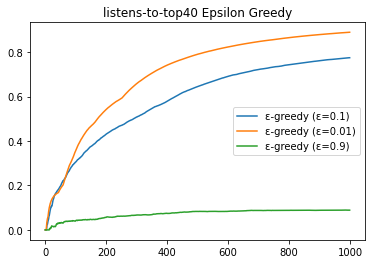

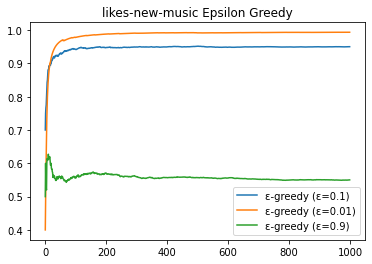

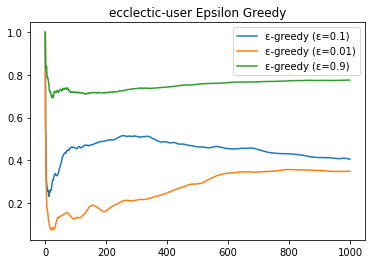

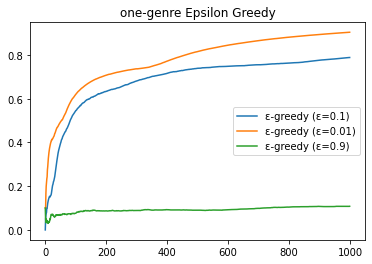

In [374]:
import matplotlib.pyplot as plt

users = [
    {
        "user": "listens-to-top40", 
        "gym": TopNGym(N=1000)
    },
    {
        "user": "likes-new-music",
        "gym": NoveltyGym(),
    },
    {
        "user": "ecclectic-user",
        "gym": DiversityGym(),
    },
    {
        "user": "one-genre",
        "gym": RewindGym()
    }
]

for user in users:
    policies = [
        EpsilonGreedyPolicy(0.1),
        EpsilonGreedyPolicy(0.01),
        EpsilonGreedyPolicy(0.9)
    ]

    for policy in policies:
        simulation = Agent(user['gym'], policy)
        rewards = simulation.run(1000)
        rewards.plot(label=policy, title='{} Epsilon Greedy'.format(user['user']))
        plt.legend()
    plt.show()

# Just actions and rewards

As you can see above the problem with taking this approach is that with four different user behaviors... the model really doesn't work well. 

100%|██████████| 400/400 [00:40<00:00,  9.80it/s]


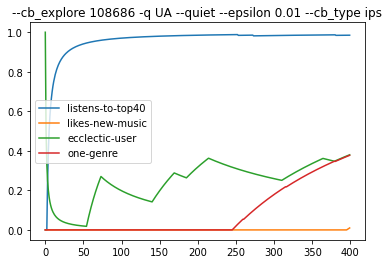

100%|██████████| 400/400 [00:43<00:00,  9.14it/s]


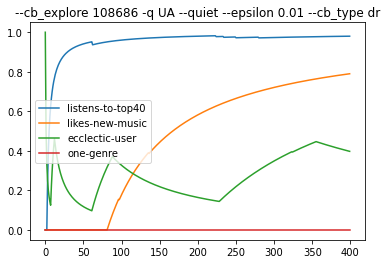

100%|██████████| 400/400 [00:41<00:00,  9.59it/s]


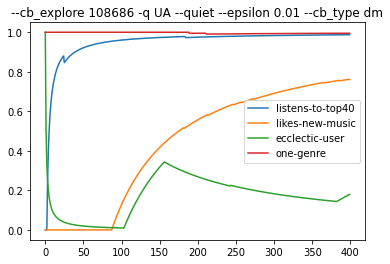

100%|██████████| 400/400 [00:43<00:00,  9.15it/s]


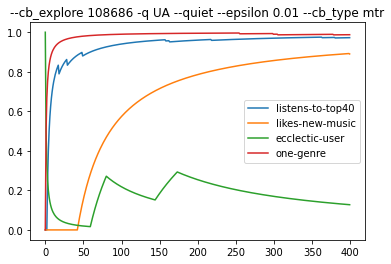

100%|██████████| 400/400 [00:44<00:00,  9.05it/s]


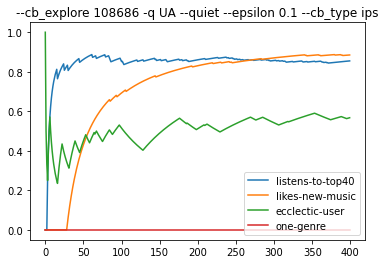

100%|██████████| 400/400 [00:45<00:00,  8.76it/s]


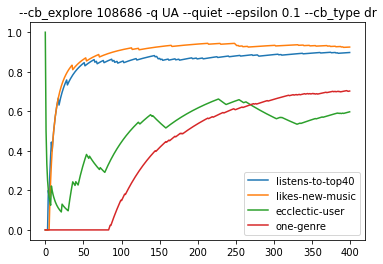

100%|██████████| 400/400 [00:43<00:00,  9.17it/s]


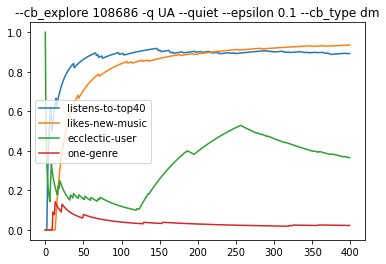

100%|██████████| 400/400 [00:46<00:00,  8.51it/s]


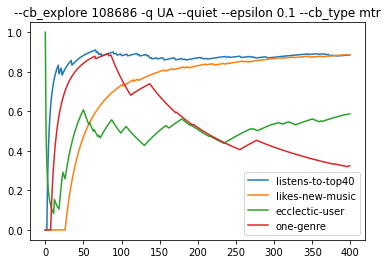

100%|██████████| 400/400 [00:44<00:00,  8.97it/s]


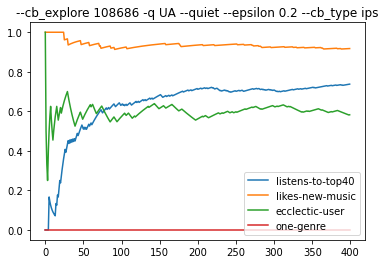

100%|██████████| 400/400 [00:45<00:00,  8.70it/s]


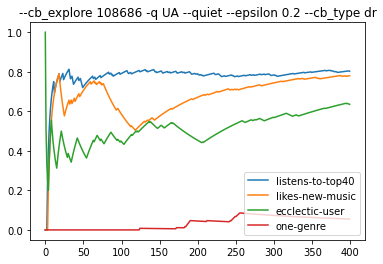

100%|██████████| 400/400 [00:44<00:00,  8.94it/s]


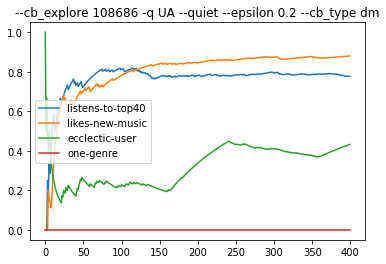

100%|██████████| 400/400 [00:46<00:00,  8.60it/s]


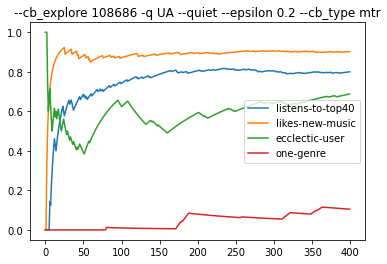

In [415]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob



def simulate(user, epochs=1000):
    rewards = []
    user['gym'].reset()
    for i in tqdm.tqdm(range(epochs)):
        username = user['user']

        action, prob = sample_custom_pmf(vw.predict(f" | User user:{user['user']}"))

        observation, reward, done, context = user['gym'].step(action)

        
        # Note that Vowpal Wabbit uses costs to optimize
        # Minimize cost given the context
        
        # -1 for reward of 1
        # +1 for reward of 0
        
        cost = -2 * reward + 1

        genre = context['genre']
        age = context['age']
        popularity = context['popularity']

        # Note that Vowpal Wabbit uses actions starting at 1 vs 0
        vw_format = f"{action+1}:{cost}:{prob} | User user:{user['user']} | Attrs genre:{genre} age:{age} popularity:{popularity}"

        vw.learn(vw_format)
        vw.finish_example(vw_format)

        rewards.append(reward)
    return rewards

for epsilon in [0.01, 0.1, 0.2]:
    for cb_type in ['ips', 'dr', 'dm', 'mtr']:
        init_str = f"--cb_explore {action_len} -q UA --quiet --epsilon {epsilon} --cb_type {cb_type}"
        vw = pyvw.vw(init_str)
        rewards = {
            user['user']: []
            for user in users
        }
        for user in users:
            rewards[user['user']] = simulate(user, 400)
        
        pd.DataFrame(rewards).expanding().mean().plot(title=init_str)
        
        plt.show()

100%|██████████| 1000/1000 [01:56<00:00,  8.61it/s]


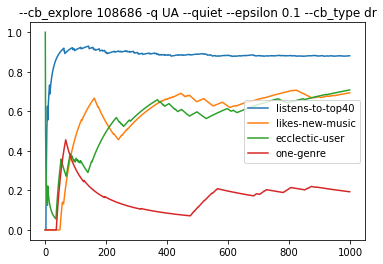

In [424]:
epsilon = 0.1
cb_type = 'dr'
init_str = f"--cb_explore {action_len} -q UA --quiet --epsilon {epsilon} --cb_type {cb_type}"

vw = pyvw.vw(init_str)

rewards = {
    user['user']: []
    for user in users
}
for user in users:
    rewards[user['user']] =  simulate(user, 1000)

pd.DataFrame(rewards).expanding().mean().plot(title=init_str)

plt.show()

In [427]:
vw.save

<bound method vw.save of <vowpalwabbit.pyvw.vw object at 0x7f8df26bdc70>>